# IAPR project 2023 G41

In [45]:
from typing import Union
from glob import glob

import os 
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import color
import scipy
import skimage
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import trange, tqdm

from iapr_g41 import IaprG41 as g41

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [46]:
g41_self = g41()

In [5]:
def show_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

### New dataset detection using edges

In [6]:
from skimage.feature import canny
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects

c:\Users\matej\anaconda3\envs\epfl_computer_vision_23\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


Text(0.5, 1.0, 'Value')

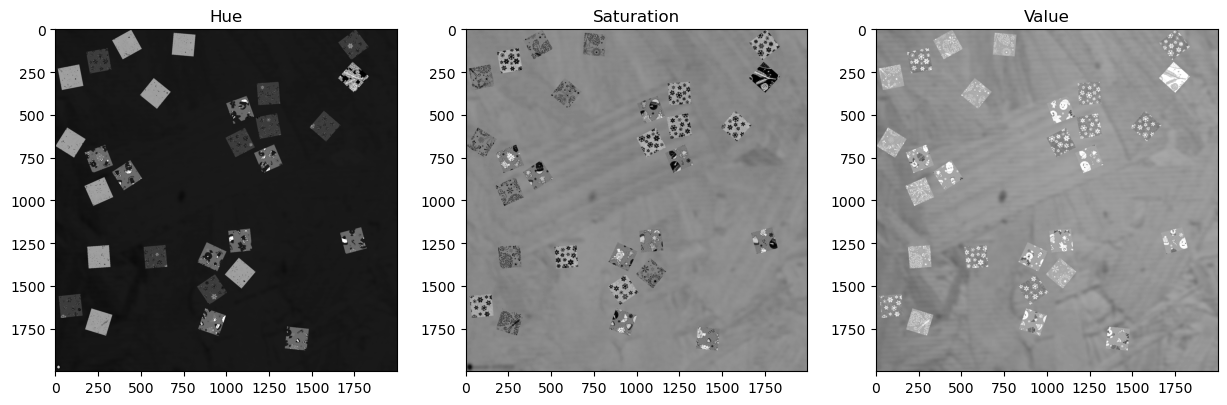

In [7]:
input_num = 0
img = g41.load_input_image(input_num)#[100:380,:350]
img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
im_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

gauss_lap = scipy.ndimage.gaussian_laplace(img_gray, 0.8)
pad_width = 50
gauss_lap_pad = np.pad(gauss_lap, pad_width, mode='constant')
closed_laplace = closing(gauss_lap_pad, disk(3))
#closed_th = g41.threshold(g41c, closed_laplace, 50, np.max(closed_laplace))
remove_laplace = remove_small_holes(closed_laplace, 40000).astype('float')

fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(15, 5))
a1.imshow(im_hsv[:,:,0],cmap='gray')
a1.set_title('Hue')

a2.imshow(im_hsv[:,:,1],cmap='gray')
a2.set_title('Saturation')

a3.imshow(im_hsv[:,:,2], cmap='gray')
a3.set_title('Value')

Text(0.5, 1.0, 'B')

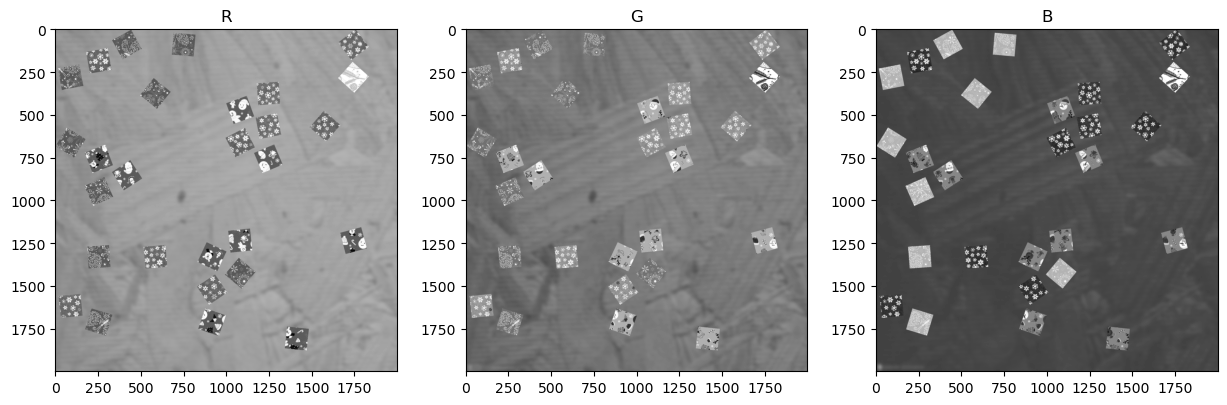

In [8]:
fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(15, 5))
a1.imshow(img[:,:,0],cmap='gray')
a1.set_title('R')

a2.imshow(img[:,:,1],cmap='gray')
a2.set_title('G')

a3.imshow(img[:,:,2], cmap='gray')
a3.set_title('B')

Text(0.5, 1.0, 'GL value')

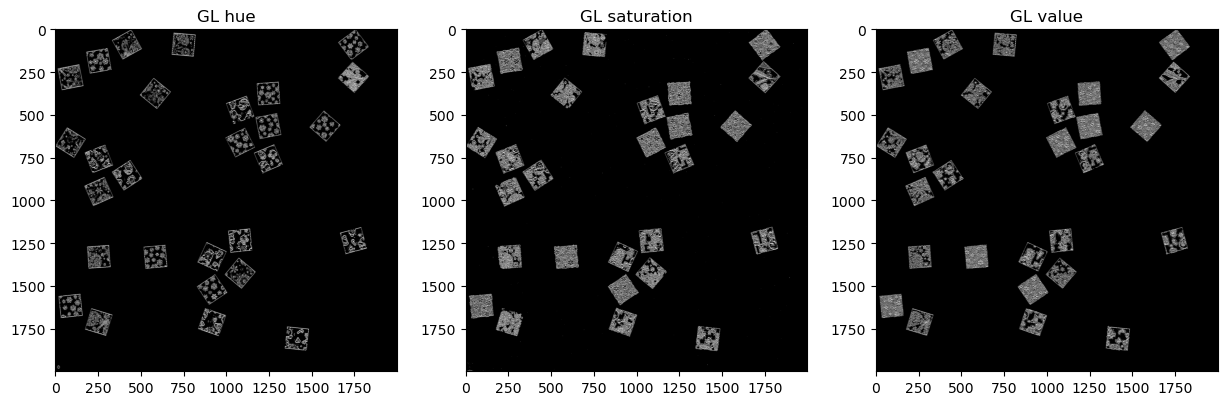

In [9]:
gl_std = 1
gauss_lap_h = scipy.ndimage.gaussian_laplace(im_hsv[:,:,0], gl_std)
gauss_lap_s = scipy.ndimage.gaussian_laplace(im_hsv[:,:,1], gl_std)
gauss_lap_v = scipy.ndimage.gaussian_laplace(im_hsv[:,:,2], gl_std)

fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(15, 5))
a1.imshow(gauss_lap_h,cmap='gray')
a1.set_title('GL hue')

a2.imshow(gauss_lap_s,cmap='gray')
a2.set_title('GL saturation')

a3.imshow(gauss_lap_v, cmap='gray')
a3.set_title('GL value')

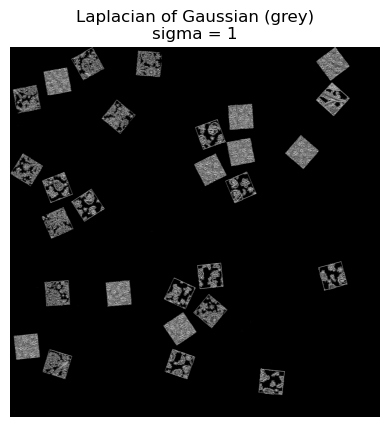

In [10]:
show_image(gauss_lap, "Laplacian of Gaussian (grey)\nsigma = 1")

In [11]:
gauss_lap_v.shape

(2000, 2000)

(2100, 2100)


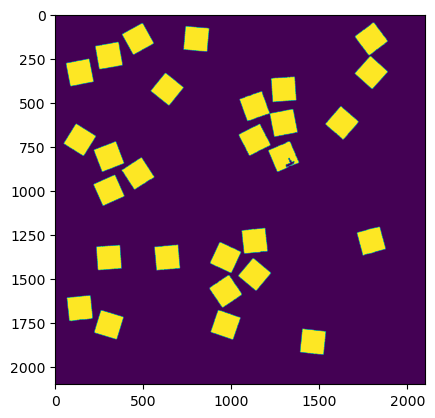

In [12]:
gl_value_pad = np.pad(gauss_lap_v, pad_width, mode='constant')
print(gl_value_pad.shape)
closed_laplace_v = closing(gl_value_pad, disk(3))
#closed_th = g41.threshold(g41c, closed_laplace, 50, np.max(closed_laplace))
remove_laplace_v = remove_small_holes(closed_laplace_v, 40000).astype('float')
plt.imshow(remove_laplace_v)

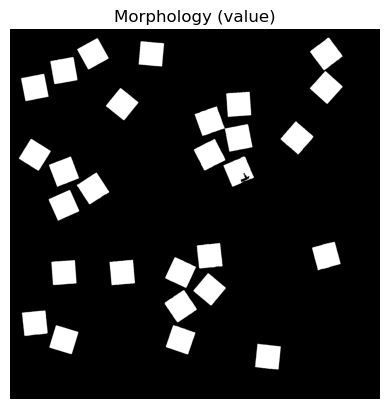

In [13]:
show_image(remove_laplace_v, "Morphology (value)")

(array([3672063.,   24443.,   52152.,   57159.,   31442.,   23881.,
          56896.,   18115.,   21922.,   41927.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

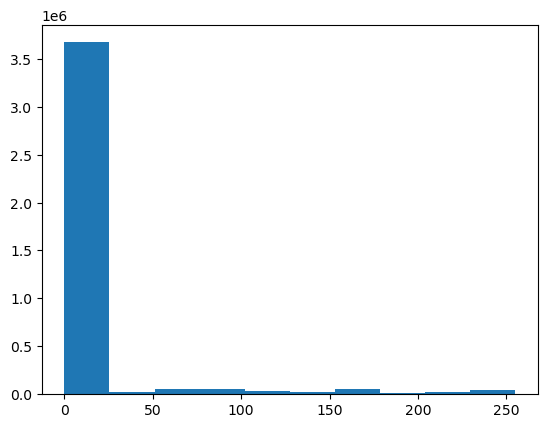

In [14]:
plt.hist(gauss_lap_v.astype(float).ravel())

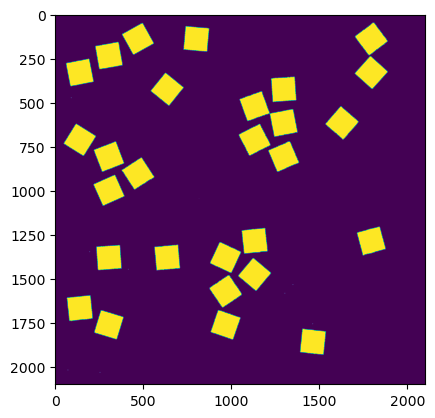

In [15]:
ultimate_combine = np.logical_or(remove_laplace, remove_laplace_v).astype(float)
plt.imshow(ultimate_combine)

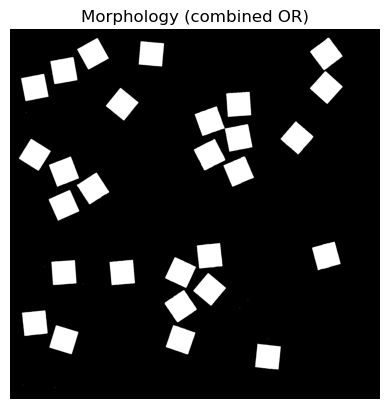

In [16]:
show_image(ultimate_combine, "Morphology (combined OR)")

(2000, 2000)


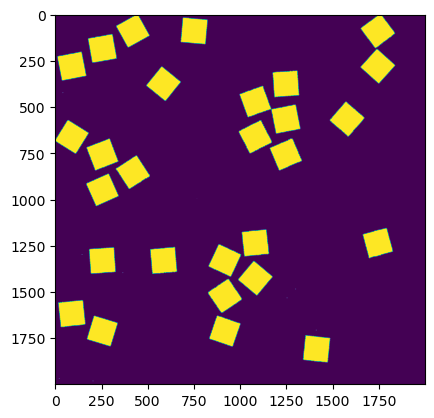

In [17]:
def remove_pad(image, pad_width):
    out = image[pad_width:-pad_width, pad_width:-pad_width]
    return out

ultimate_combine_unpad = remove_pad(ultimate_combine, pad_width)
plt.imshow(ultimate_combine_unpad)
print(ultimate_combine_unpad.shape)

Text(0.5, 1.0, 'Remove small holes')

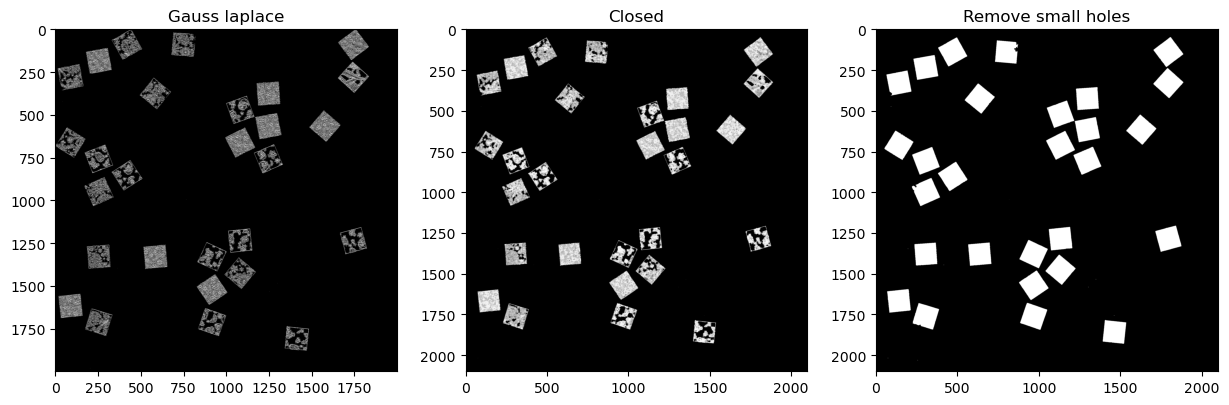

In [18]:

fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(15, 5))
a1.imshow(gauss_lap,cmap='gray')
a1.set_title('Gauss laplace')

a2.imshow(closed_laplace,cmap='gray')
a2.set_title('Closed')

a3.imshow(remove_laplace, cmap='gray')
a3.set_title('Remove small holes')

In [19]:
from skimage.measure import label, regionprops

In [20]:
from skimage.transform import probabilistic_hough_line
from numpy.linalg import norm

### Centroids from regionprops

In [21]:
morph_label = label(ultimate_combine_unpad)
morph_regions = regionprops(morph_label)

[(90.86100044267376, 1744.8522576361222), (90.33479630880036, 420.3457123565159), (90.72460904420483, 751.8621916106814), (185.7897000502709, 255.74183097804837), (281.6721926631196, 1744.7202464295715), (281.326419336706, 90.36329398538504), (376.3188112124282, 586.1967240797028), (376.93086031763846, 1247.7140692519222), (520.4418389645318, 1165.5358043368633), (567.4310885964429, 1578.5983701338032), (663.5071143355267, 90.44221359878522), (663.4053415398142, 1082.513326372479), (758.3671201814059, 1247.139342403628), (758.8232087665075, 255.93947738128688), (854.7616864742502, 420.81182795698925), (949.8713555418235, 255.78686590640976), (1237.0195503972054, 1744.7501267677053), (1236.8168263507002, 1082.7528771472305), (1331.578023590496, 917.3274451154128), (1331.734296800315, 586.9376933025924), (1331.9591699004554, 255.71058995557055), (1427.4052078060852, 1082.4243855801135), (1523.1781320681855, 918.2056600650963), (1618.8372553456272, 90.65652223102161), (1713.4768249308418,

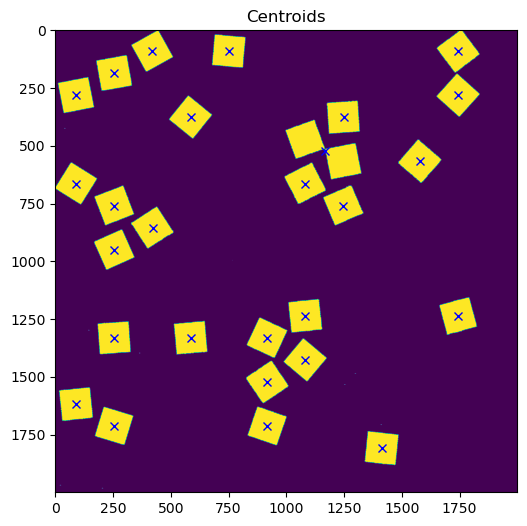

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(ultimate_combine_unpad)
ax.set_title("Centroids")
#for i in range(len(peaks)):
#        ax.plot(peaks[i][1], peaks[i][0], marker='x', color='red')
found_centroids = []
for reg in morph_regions:
        if reg.area > 1000:
                ax.plot(reg.centroid[1], reg.centroid[0], marker='x', color='blue')
                found_centroids.append(reg.centroid)
                #print(reg.orientation)

print(found_centroids)

plt.show()

### Centroids from peaks

In [23]:
locations = g41.find_squares(g41_self, ultimate_combine_unpad)
smooth_loc= scipy.ndimage.gaussian_filter(locations, 10)
locations_norm = g41.norm_data(smooth_loc)

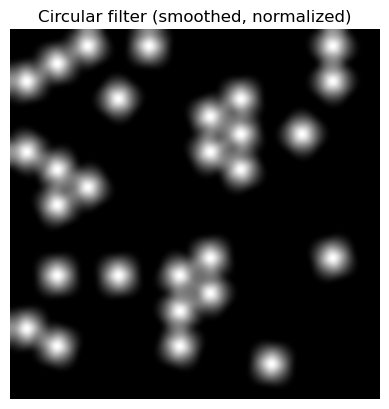

In [24]:
show_image(locations_norm, "Circular filter (smoothed, normalized)")

In [25]:
peaks = g41.travel_to_peaks(g41_self, locations_norm)

(-0.5, 1999.5, 1999.5, -0.5)

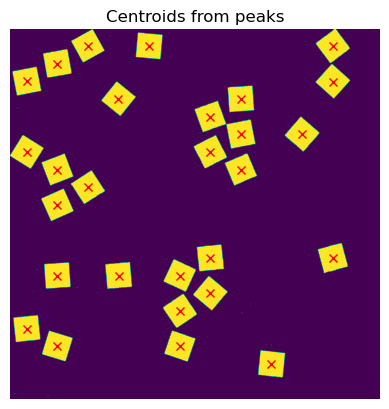

In [26]:
fig, ax = plt.subplots()
ax.imshow(ultimate_combine_unpad)
for i in range(len(peaks)):
        ax.plot(peaks[i][1], peaks[i][0], marker='x', color='red')
ax.set_title('Centroids from peaks')
ax.axis('off')

### Centroids from contours

In [27]:
import imutils

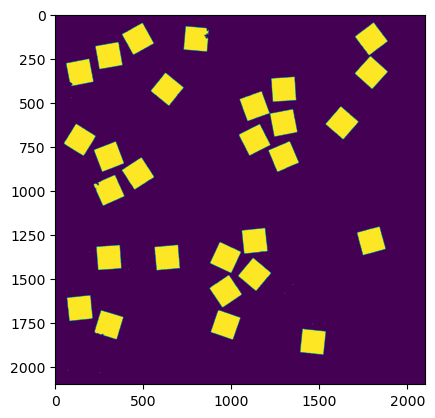

In [28]:
remove_lapl_int = (remove_laplace*255).astype(np.uint8)
plt.imshow(remove_lapl_int)

In [29]:
cnts = cv.findContours(remove_lapl_int, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

for c in cnts:
    area = cv.contourArea(c)
    cv.drawContours(remove_lapl_int, [c], -1, (0,255,0), 3)
    M = cv.moments(c)
    #cx = int(M["m10"]/M["m00"])
    #cy = int(M["m01"]/M["m00"])

    #cv.circle(remove_laplace, (cx,cy),7,(255,255,255),-1)

#plt.imshow(remove_lapl_int)

NameError: name 'cx' is not defined

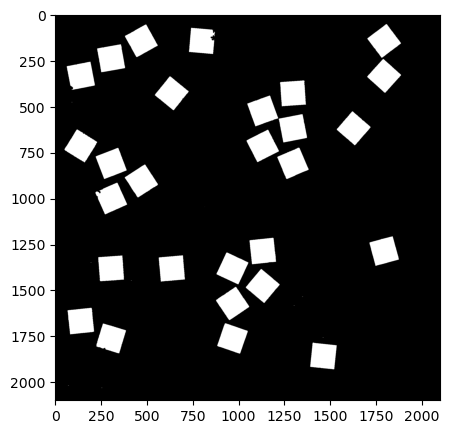

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.imshow(remove_laplace, cmap='gray')
for c in cnts:
    contour = c.reshape(-1, 2)
    # Plot the contour
    plt.plot(contour[:, 0], contour[:, 1], linewidth=2)
    M = cv.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"]/M["m00"])
        cy = int(M["m01"]/M["m00"])
    #print((cy,cx))
    axes.plot(cx, cy, 'xb')
    

In [31]:
from sklearn.cluster import KMeans

In [ ]:
def calculate_center(contour):
    moments = cv.moments(contour)
    if moments['m00'] != 0:  # Check if the area is non-zero
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        return (cx, cy)
    else:
        return None

new_contours = [contour for contour in cnts if calculate_center(contour) is not None]
# Calculate centers
centers = [calculate_center(contour) for contour in new_contours]

# Perform clustering
K = len(peaks)
#print(K)
X = np.array(centers)
kmeans = KMeans(n_clusters=K)  # K is the number of clusters you want to create
kmeans.fit(X)

# Retrieve labels
labels = kmeans.labels_
cont_centers = kmeans.cluster_centers_

# Group contours based on clusters
cont_clusters = [[] for _ in range(K)]
for i, contour in enumerate(new_contours):
    if calculate_center(contour) is not None:
        cont_clusters[labels[i]].append(contour)

c:\Users\matej\anaconda3\envs\epfl_computer_vision_23\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [39]:
from itertools import cycle

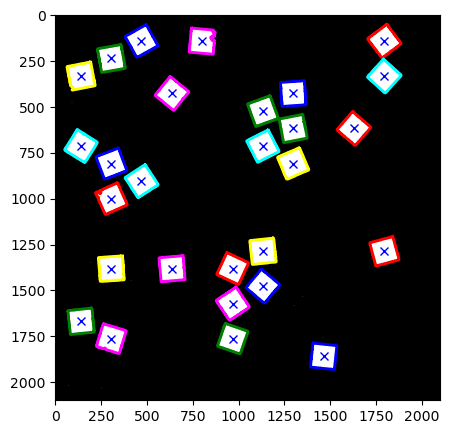

In [ ]:
colors = ['red', 'blue', 'magenta', 'green', 'yellow', 'cyan']
color_pool = cycle(colors)

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.imshow(remove_laplace, cmap='gray')
for cluster in cont_clusters:
    color = next(color_pool)
    for c in cluster:
        contour = c.reshape(-1, 2)
        # Plot the contour
        plt.plot(contour[:, 0], contour[:, 1], linewidth=2, color=color)
        #print((cy,cx))
for cent in cont_centers:
    cx = cent[0]
    cy = cent[1]
    axes.plot(cx, cy, 'xb')

### Probabilistic Hugh Transform

In [32]:
def cluster_lines(centroids, lines, debug=False):
    clusters = [[] for i in range(len(centroids))]
    
    for i in range(len(lines)):
        index = 0
        d_min = float('inf')
        if debug:
            print(f"Line {lines[i]}")
        for j in range(len(centroids)):
            if debug:
                print(f"Centroid {centroids[j]}")
            d = g41.my_dist(lines[i], centroids[j])
            if debug:
                print(f"Distance {d}")
            if d < d_min:
                if debug:
                    print(f"Yes")
                d_min = d
                index = j
            else:
                if debug:
                    print("No")
        clusters[index].append(lines[i])
    return clusters

In [33]:
def get_angle(line):
    p0 = line[0]
    p1 = line[1]
    d0 = p0[0] - p1[0]
    d1 = p0[1] - p1[1]
    angle_rad = np.arctan2(d1,d0)
    #print(f"Original angle {angle_rad}")
    
    if angle_rad < 0:
        angle_rad += np.pi
    if angle_rad > np.pi/2:
        angle_rad -= np.pi/2

    #print(f"Angle in radians: {angle_rad}")
    angle_deg = np.rad2deg(angle_rad)
    return angle_rad, angle_deg

def get_square_points(centroid, angle_rad, side_lenght = 129):
    h = side_lenght / np.sqrt(2)  # half-diagonal length
    cx = centroid[1]
    cy = centroid[0]
    
    # Calculate the coordinates of the four points
    dx = h * np.cos(angle_rad + np.pi / 4)
    dy = h * np.sin(angle_rad + np.pi / 4)

    point1 = (cx - dx, cy - dy)
    point2 = (cx + dy, cy - dx)
    point3 = (cx + dx, cy + dy)
    point4 = (cx - dy, cy + dx)

    return point1, point2, point3, point4

(1.5707963267948966, 90.0)


(-0.65, 2.65, -0.725, 4.225)

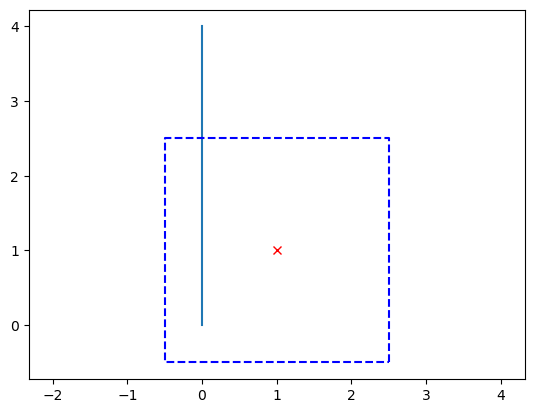

In [34]:
centr = np.array([1,1])
my_line0 = np.array([[0,0],[0,4]])
angles = get_angle(my_line0)
print(angles)
s1,s2,s3,s4 = get_square_points(centr, angles[0], side_lenght=3)

p00 = my_line0[0]
p01 = my_line0[1]
plt.plot((p00[0], p01[0]), (p00[1], p01[1]))
plt.plot(centr[1],centr[0], 'rx')
plt.plot((s1[0], s2[0], s3[0], s4[0], s1[0]), (s1[1], s2[1], s3[1], s4[1], s1[1]), '--b')
plt.axis('equal')

In [ ]:
print(len(cont_centers))

28


### Squares from edges

In [52]:
edge_close_th = canny(ultimate_combine_unpad, sigma = 3)
lines = probabilistic_hough_line(edge_close_th, threshold=10, line_length=80, line_gap=20)
# threshold=10, line_length=80, line_gap=20
#clusters = cluster_lines(found_centroids, lines)
squares = g41.get_squares(g41_self, peaks, lines)

In [67]:
for index, square in enumerate(squares):
        angles_degrees = [np.rad2deg(angle) for angle in square.all_angles]
        formatted_angles = [f"{angle:2.0f}" for angle in angles_degrees]
        my_med = np.median(angles_degrees)
        print(f"Square {index}: {my_med:2.0f} {formatted_angles}")

Square 0: 61 ['60', '61', '61', '61', '60', '61', '61']
Square 1:  5 [' 5', ' 5', ' 5', ' 5', ' 5', ' 5', ' 5']
Square 2: 53 ['54', '52', '52', '53', '54', '53', '53', '53', '54']
Square 3: 80 ['80', '79', '80', '80', '79', '80', '80']
Square 4: 79 ['79', '79', '79', '79', '79']
Square 5: 42 ['42', '42', '42', '42', '42', '42', '42', '42', '42']
Square 6: 39 ['39', '39', '39', '40', '39', '39', '39', '39', '39']
Square 7: 86 ['86', '86', '87', '86', '86']
Square 8: 70 ['71', '70', '70', '70', '71', '70', '70']
Square 9: 79 ['79', '79', '78', '79', '79', '79', '79']
Square 10: 41 ['41', '41', '41', '41', '41', '41', '40', '41', '40']
Square 11: 63 ['63', '63', '63', '63', '62']
Square 12: 32 ['33', '32', '32', '31', '32', '32', '32', '32', '32']
Square 13: 67 ['67', '67', '66', '66', '67']
Square 14: 69 ['69', '69', '69', '69', '69', '69', '69']
Square 15: 57 ['57', '57', '57', '57', '57', '58', '57', '57', '57']
Square 16: 66 ['66', '66', '66', '66', '66', '66', '66']
Square 17: 84 ['8

(-0.5, 1999.5, 1999.5, -0.5)

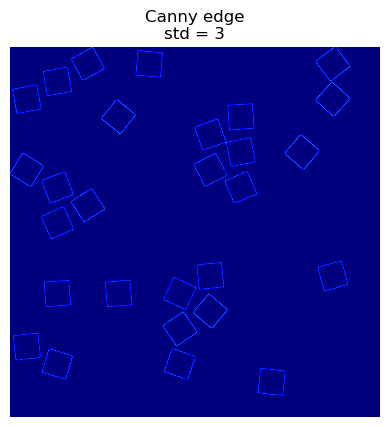

In [37]:
plt.imshow(edge_close_th, cmap='jet')
plt.title("Canny edge\nstd = 3")
plt.axis('off')

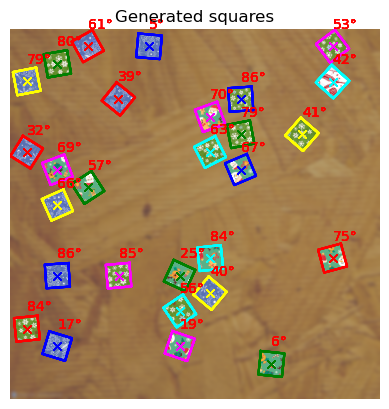

In [41]:
# Generating figure 2
fig, axes = plt.subplots()
ax=axes

colors = ['red', 'blue', 'magenta', 'green', 'yellow', 'cyan']
color_pool = cycle(colors)
ax.imshow(img)

#for line in lines:
#    p0, p1 = line
#    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
num = 0
for sq in squares:
    color = next(color_pool)
    for line in sq.lines:
        p0, p1 = line
        #ax.plot((p0[0], p1[0]), (p0[1], p1[1]), color=color)
        c = sq.centroid
        ax.plot(c[1], c[0], marker='x', color=color)
        deg = np.rad2deg(sq.angle)
        #ax.text(c[1], c[0]-100, f"{num}", color='r')
        ax.text(c[1], c[0]-100, f"{deg:0.0f}°", color='r')
    

        angle = sq.angle
        s1,s2,s3,s4 = sq.square_points
        ax.plot((s1[0], s2[0], s3[0], s4[0], s1[0]), (s1[1], s2[1], s3[1], s4[1], s1[1]), color=color)
    num += 1
        #break
    
ax.set_title('Generated squares')
ax.axis('off')

#print("Lines", lines)
#print("Centroids", found_centroids)
#print("Clusters", clusters)

plt.show()


### RANSAC fit circles

In [ ]:
import numpy as np
import random
from scipy.optimize import least_squares


def circle_eq(params, x, y):
    cx, cy, r = params
    return (x - cx) ** 2 + (y - cy) ** 2 - r ** 2


def residuals(params, x, y):
    return circle_eq(params, x, y)


def fit_circle(x, y):
    cx = np.mean(x)
    cy = np.mean(y)
    r = np.mean(np.sqrt((x - cx) ** 2 + (y - cy) ** 2))

    initial_params = [cx, cy, r]
    result = least_squares(residuals, initial_params, args=(x, y))

    return result.x


def ransac_circle_fit(x, y, num_iterations, threshold_distance, inlier_ratio):
    best_circle = None
    best_inliers = []
    max_inliers = 0

    for _ in range(num_iterations):
        random_indices = random.sample(range(len(x)), 3)
        sample_x = x[random_indices]
        sample_y = y[random_indices]

        circle_params = fit_circle(sample_x, sample_y)

        distances = np.abs(residuals(circle_params, x, y))
        inliers = np.where(distances < threshold_distance)[0]

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_circle = circle_params
            best_inliers = inliers

        if max_inliers >= inlier_ratio * len(x):
            break

    return best_circle, best_inliers


# Example usage
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([9, 8, 7, 6, 5, 4, 3, 2, 1])

best_circle, inliers = ransac_circle_fit(x, y, num_iterations=100, threshold_distance=0.1, inlier_ratio=0.8)
if best_circle is not None:
    print("Circle parameters:", best_circle)
else:
    print("Circle fitting failed.")
print("Inliers:", inliers)


Circle fitting failed.
Inliers: []


In [ ]:
def quad_to_center(d, e):
    x0 = -d / 2
    y0 = -e / 2
    return (x0, y0)

In [ ]:
def dist_for_circles(X, x0, y0, radius):
    diff = X - np.array([x0, y0]).reshape(1, 2)
    my_norm = np.sqrt(diff[:, 0]**2 + diff[:, 1]**2)
    d = my_norm - radius
    return d

In [ ]:
def fit_circle_ransac(X, num_iter, threshold, radius):
    dim1 = len(X)
    point_n = 3
    A = np.ones((point_n, 3))
    max_inlier = 0
    b_x0 = 0
    b_y0 = 0

    for i in range(num_iter):
        sample_indices = np.random.choice(dim1, point_n, replace=False)
        sample = X[sample_indices]
        A[:, 0] = sample[:, 0]
        A[:, 1] = sample[:, 1]

        b = -(sample[:, 0]**2 + sample[:, 1]**2 - radius**2)
        out = np.linalg.lstsq(A, b, rcond=None)[0]

        d = out[0]
        e = out[1]
        f = out[2]

        x0, y0 = quad_to_center(d, e)
        act_dist = dist_for_circles(X, x0, y0, radius)
        cond = np.abs(act_dist) < threshold
        inlier = X[cond, :].shape[0]
        if inlier > max_inlier:
            max_inlier = inlier
            b_x0 = x0
            b_y0 = y0

    return b_x0, b_y0, radius, max_inlier

In [ ]:
print(np.mean(squares[0].points_from_edges, axis=0))
print(squares[0].centroid)

[413.94444444  93.55555556]
[ 90 420]


In [ ]:
fit_circle_ransac(squares[0].points_from_edges, 100, 0.1, 150)

(462.8805914454994, 161.68771864360403, 150, 3)

### RANSAC fit squares

In [ ]:
'''
import numpy as np
from sklearn.metrics import pairwise_distances

def fit_square_ransac(points, rotation_angle, distance_threshold = 1, num_iterations=20, square_size=128, dist_flag = 'pairwise'):
    best_square = None
    best_inliers = []
    
    for _ in range(num_iterations):
        # Randomly select four points from the cloud
        sample_indices = np.random.choice(len(points), 4, replace=False)
        sample = points[sample_indices]

        # Fit a square to the sampled points
        square = fit_square(sample, square_size, rotation_angle)

        # Calculate distances between all points and the fitted square
        if dist_flag == 'pairwise':
            distances = pairwise_distances(points, square)
        else:
            distances = calculate_distances(points, square)
            
        # Find inliers within a threshold distance
        inliers = np.where(distances < distance_threshold)[0]
        
        # Check if this iteration produced a better fit
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_square = square
            
    #print(best_square)
    return best_square, best_inliers

def calculate_distances(points, square):
    # Calculate distances from points to the closest side of the square
    distances = []
    for point in points:
        min_distance = np.inf
        for i in range(len(square)):
            p1, p2 = square[i], square[(i + 1) % len(square)]
            distance = point_to_line_distance(point, p1, p2)
            min_distance = min(min_distance, distance)
        distances.append(min_distance)
    return np.array(distances)

def point_to_line_distance(point, line_start, line_end):
    # Calculate the perpendicular distance from a point to a line segment
    line_vec = line_end - line_start
    point_vec = point - line_start
    line_length = np.linalg.norm(line_vec)
    line_dir = line_vec / line_length
    proj = np.dot(point_vec, line_dir)
    proj = np.clip(proj, 0, line_length)
    closest_point = line_start + proj * line_dir
    distance = np.linalg.norm(point - closest_point)
    return distance

def fit_square(points, square_size, rotation_angle):
    
    # Translate the square to the centroid of the points
    centroid = np.mean(points, axis=0)

    h = square_size / np.sqrt(2)  # half-diagonal length
    cx = centroid[0]
    cy = centroid[1]
    
    # Calculate the coordinates of the four points
    dx = h * np.cos(rotation_angle + np.pi / 4)
    dy = h * np.sin(rotation_angle + np.pi / 4)

    point1 = (cx - dx, cy - dy)
    point2 = (cx + dy, cy - dx)
    point3 = (cx + dx, cy + dy)
    point4 = (cx - dy, cy + dx)

    square = np.array([point1, point2, point3, point4])
    
    return square

squares_out = []
inliners_out = []
for i in trange(len(squares)):
    sq = squares[i]
    points = sq.points_from_edges
    rotation_angle = sq.angle
    sq_out, inline_out = fit_square_ransac(points, rotation_angle, dist_flag='other')
    squares_out.append(sq_out)
    inliners_out.append(inline_out)
'''

"\nimport numpy as np\nfrom sklearn.metrics import pairwise_distances\n\ndef fit_square_ransac(points, rotation_angle, distance_threshold = 1, num_iterations=20, square_size=128, dist_flag = 'pairwise'):\n    best_square = None\n    best_inliers = []\n    \n    for _ in range(num_iterations):\n        # Randomly select four points from the cloud\n        sample_indices = np.random.choice(len(points), 4, replace=False)\n        sample = points[sample_indices]\n\n        # Fit a square to the sampled points\n        square = fit_square(sample, square_size, rotation_angle)\n\n        # Calculate distances between all points and the fitted square\n        if dist_flag == 'pairwise':\n            distances = pairwise_distances(points, square)\n        else:\n            distances = calculate_distances(points, square)\n            \n        # Find inliers within a threshold distance\n        inliers = np.where(distances < distance_threshold)[0]\n        \n        # Check if this iteration pr

In [ ]:
'''
# Generating figure 2
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(edge_close_th, cmap='jet')
ax[0].set_title('Canny')

colors = ['red', 'blue', 'magenta', 'green', 'yellow', 'cyan']
color_pool = cycle(colors)
ax[1].imshow(img, cmap='gray')

#for line in lines:
#    p0, p1 = line
#    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
for sq in squares:
    color = next(color_pool)
    c = sq.all_contour_points
    contour = c.reshape(-1, 2)
        # Plot the contour
    plt.plot(contour[:, 0], contour[:, 1], '--r')

for ransac_sq in squares_out:
    if ransac_sq is not None:
        s1,s2,s3,s4 = ransac_sq
        ax[1].plot((s1[0], s2[0], s3[0], s4[0], s1[0]), (s1[1], s2[1], s3[1], s4[1], s1[1]), '--y')

        #break
    
ax[1].set_title('Probabilistic Hough')

print("Lines", lines)
print("Centroids", found_centroids)
#print("Clusters", clusters)

plt.show()
'''


'\n# Generating figure 2\nfig, axes = plt.subplots(1, 2, figsize=(15, 5))\nax = axes.ravel()\n\nax[0].imshow(edge_close_th, cmap=\'jet\')\nax[0].set_title(\'Canny\')\n\ncolors = [\'red\', \'blue\', \'magenta\', \'green\', \'yellow\', \'cyan\']\ncolor_pool = cycle(colors)\nax[1].imshow(img, cmap=\'gray\')\n\n#for line in lines:\n#    p0, p1 = line\n#    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))\nfor sq in squares:\n    color = next(color_pool)\n    c = sq.all_contour_points\n    contour = c.reshape(-1, 2)\n        # Plot the contour\n    plt.plot(contour[:, 0], contour[:, 1], \'--r\')\n\nfor ransac_sq in squares_out:\n    if ransac_sq is not None:\n        s1,s2,s3,s4 = ransac_sq\n        ax[1].plot((s1[0], s2[0], s3[0], s4[0], s1[0]), (s1[1], s2[1], s3[1], s4[1], s1[1]), \'--y\')\n\n        #break\n    \nax[1].set_title(\'Probabilistic Hough\')\n\nprint("Lines", lines)\nprint("Centroids", found_centroids)\n#print("Clusters", clusters)\n\nplt.show()\n'

In [ ]:
squares[17].angle

1.4663392033212754

In [ ]:
from PIL import ImageDraw
from matplotlib import cm

### Crop squares bigger

In [ ]:
def edge_image_fix(image, flag='edge'):

    edge = 3

    # Split the image into individual color channels
    channels = cv.split(image)

    if flag == 'inpaint':
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        mask[:edge, :] = 1
        mask[-edge:, :] = 1
        mask[:, :edge] = 1
        mask[:,-edge:] = 1

        # Apply inpainting to each color channel separately
        inpainted_channels = []
        for channel in channels:
            # Apply inpainting to the channel
            inpainted_channel = cv.inpaint(channel, mask, 3, cv.INPAINT_TELEA)
            inpainted_channels.append(inpainted_channel)

        # Merge the inpainted color channels back into an RGB image
        out = cv.merge(inpainted_channels)
    else:
        mirrored_channels = []
        for channel in channels:
            cropped_channel = channel[edge:-edge, edge:-edge]
            padded_channels = np.pad(cropped_channel, edge, mode='edge')
            mirrored_channels.append(padded_channels)
        out = cv.merge(mirrored_channels)
        #print(out.shape)

    return out

In [ ]:
def crop_square_bigger(image_path, points, angle):
    # Open the image
    image = Image.open(image_path)

    # Create a new image with an RGBA mode and transparent background
    cropped_image = Image.new("RGBA", image.size, (0, 0, 0, 0))

    # Create a mask based on the given points
    mask = Image.new("RGBA", image.size, (0, 0, 0, 0))
    mask_points = [tuple(point) for point in points]
    
    mask_points.append(mask_points[0])
    ImageDraw.Draw(mask).polygon(mask_points, outline=(255, 255, 255, 255), fill=(255, 255, 255, 255))

    # Apply the mask to the original image
    cropped_image.paste(image, mask=mask)

    # Crop the image to the minimum bounding rectangle
    cropped_image = cropped_image.crop(mask.getbbox())

    # Rotate image
    #cropped_image = cropped_image.rotate(np.rad2deg(angle))

    # Find bounding box
    image_gray = cropped_image.convert("L")

    # Find the bounding box of the non-white pixels
    bbox = image_gray.getbbox()

    # Crop
    cropped_image = cropped_image.crop(bbox)

    # Resize to 128x128
    #trimmed_image = cropped_image.resize(image_size)

    # Inpaint edges to get rid of background artefacts
    inpainted_image = edge_image_fix(np.array(cropped_image))

    # Save the inpainted image
    #cropped_image.save(save_path)

    return np.array(cropped_image)

bigger_squares = []
for sq in squares:
    #out_path = f"output/output_{input_num:02}_{num:02}.png"
    #num +=1
    whole_im_path = f"data_project/train2/train_{input_num:02}.png"
    cropped_image = crop_square_bigger(whole_im_path, sq.bigger_square_points, sq.angle)
    bigger_squares.append(cropped_image)
#print(squares[0].square_points)

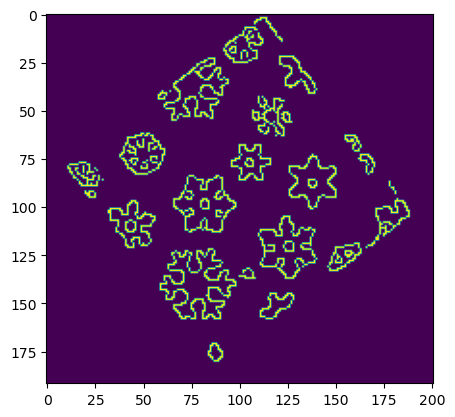

In [ ]:
gray = cv.cvtColor(bigger_squares[2], cv.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')
edge = scipy.ndimage.gaussian_laplace(gray, 0.8)
edge = canny(gray)
plt.imshow(edge)

### Crop squares out

In [ ]:
def crop_square(image_path, points, save_path, angle, image_size=(128,128)):
    # Open the image
    image = Image.open(image_path)

    # Create a new image with an RGBA mode and transparent background
    cropped_image = Image.new("RGBA", image.size, (0, 0, 0, 0))

    # Create a mask based on the given points
    mask = Image.new("RGBA", image.size, (0, 0, 0, 0))
    mask_points = [tuple(point) for point in points]
    
    mask_points.append(mask_points[0])
    ImageDraw.Draw(mask).polygon(mask_points, outline=(255, 255, 255, 255), fill=(255, 255, 255, 255))

    # Apply the mask to the original image
    cropped_image.paste(image, mask=mask)

    # Crop the image to the minimum bounding rectangle
    cropped_image = cropped_image.crop(mask.getbbox())

    # Rotate image
    cropped_image = cropped_image.rotate(np.rad2deg(angle))

    # Find bounding box
    image_gray = cropped_image.convert("L")

    # Find the bounding box of the non-white pixels
    bbox = image_gray.getbbox()

    # Crop
    trimmed_image = cropped_image.crop(bbox)

    # Resize to 128x128
    trimmed_image = trimmed_image.resize(image_size)

    # Inpaint edges to get rid of background artefacts
    edge_fixed = edge_image_fix(np.array(trimmed_image), flag='s')
    #print(edge_fixed.dtype)

    # Save the inpainted image
    Image.fromarray(edge_fixed).save(save_path)
    #trimmed_image.save(save_path)

    return edge_fixed

num = 0
for sq in squares:
    out_path = f"output/output_{input_num:02}_{num:02}.png"
    num +=1
    whole_im_path = f"data_project/train2/train_{input_num:02}.png"
    cropped_image = crop_square(whole_im_path, sq.square_points, out_path, sq.angle)
#print(squares[0].square_points)

In [ ]:
print(cropped_image.shape)

(128, 128, 4)


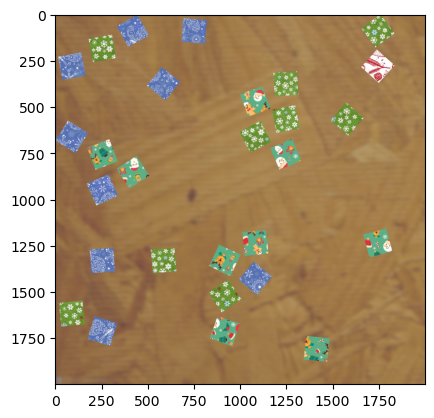

In [ ]:
image = Image.open(whole_im_path)
plt.imshow(image)

In [ ]:
input_num

0

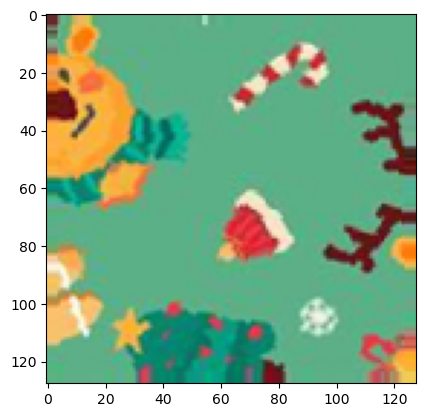

In [ ]:
plt.imshow(cropped_image)

In [ ]:
print(cropped_image.size[:2])
mask = np.zeros(cropped_image.size[:2])
mask[:2, :] = 1
mask[-2:, :] = 1
mask[:, :2] = 1
mask[:,-2:] = 1
mask = mask.astype('int8')

plt.imshow(mask)

print(mask.dtype)
mask.shape

TypeError: 'int' object is not subscriptable